In [1]:
from infopath.model_loader import load_model_and_optimizer
from infopath.config import load_training_opt, compare_opt, save_opt
import matplotlib.pyplot as plt
import torch 
import numpy as np
from infopath.utils.functions import run_with_perturbation
import os
from infopath.utils.plot_utils import plot_with_size, strip_right_top_axis
import pandas as pd
from infopath.losses import trial_matching_loss, hard_trial_matching_loss
from geomloss import SamplesLoss
from infopath.utils.functions import trial_metric
import random 

%reload_ext autoreload
%autoreload 2
font = {"size": 6, "family":"arial"}
import matplotlib

matplotlib.rc("font", **font)
matplotlib.rcParams["pdf.fonttype"] = 42

In [2]:
# set seed for reproducibility
seed = 1
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic=True

In [3]:
os.chdir("..")

In [4]:
logs = {
    "nofb": 
    [
        "log_dir/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf_block/",
        
        # Full
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_42_nofb_full_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_42_nofb_full_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_45_nofb_full_2",
        
        # no sparsity 
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_nosparsity_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nosparsity_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nosparsity_2",
        
        # with inh across
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_noinhacross_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_noinhacross_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_noinhacross_2",

        # no EI
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_45_nofb_noei_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_46_nofb_noei_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_46_nofb_noei_2",
        
        # no tm
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_36_6_nofb_notm_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_5_48_nofb_notm_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_46_19_nofb_notm_2",

        # no spike
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nospike_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nospike_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_45_nofb_nospike_2",

        # # no spike + reset 
        # "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_45_nofb_nospikereset_0",
        # "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_45_nofb_nospikereset_1",
        # "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_45_nofb_nospikereset_2",

        # sigmoid
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_nofb_sigmoid_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_nofb_sigmoid_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_nofb_sigmoid_2",
        ],
    "withfb1":
    [
        "log_dir/1d74764c4551eef5158418ea67fbe1a5885dfdb1/2024_5_27_9_46_33_teacher_conf/",

        # Full
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_44_withfb1_full_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_withfb1_full_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_full_2",
        
        # no sparsity 
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_26_withfb1_nosparsity_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_38_withfb1_nosparsity_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_2_32_withfb1_nosparsity_2",

        # with inh across
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_noinhacross_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_noinhacross_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_25_withfb1_noinhacross_2",
        
        # no ei
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_noei_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_44_25_withfb1_noei_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_36_withfb1_noei_2",

        # no tm
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_2_48_withfb1_notm_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_3_54_withfb1_notm_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_4_31_withfb1_notm_2",
        
        # no spike
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_1_30_withfb1_nospike_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_7_46_withfb1_nospike_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_7_46_withfb1_nospike_2",
        
        # # no spike + reset 
        # "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_54_23_withfb1_nospikereset_0",
        # "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_7_46_withfb1_nospikereset_1",
        # "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_3_42_withfb1_nospikereset_2",
        
        # sigmoid
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_6_2_withfb1_sigmoid_0",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_6_30_withfb1_sigmoid_1",
        "log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_6_40_withfb1_sigmoid_2",
        ]
}

In [5]:
def give_name(log):
    if "notm" in log:
        return "No TM"
    if "noinhacross_noei" in log:
        return "Non-local inhibition"
    if "noinhacross" in log:
        return "Non-local inhibition"
    if "noei" in log:
        return "No Dale's law"
    if "nosparsity" in log:
        return "No sparsity"
    if "nospike" in log:
        if "reset" in log:
            return "No spike + reset"
        return "No spike"
    if "sigmoid" in log:
        return "Sigmoid"
    return "Full rec. method"

thr = 8

In [ ]:
# This is meant to be run once, it is computationally expensive
# trials = 2000
# for hypothesis in ["withfb1", "nofb"]:
#     try:
#         df = pd.read_csv(f"FiguresOpto/{hypothesis}_t_trial_loss.csv")
#     except:
#         df = pd.DataFrame(columns=("hypothesis", "model_name", "t_trial_21", "t_trial12", "power", "activation", "seed"))
#     opt = load_training_opt(logs[hypothesis][0])
#     m_teacher = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
#     filt = lambda x: m_teacher.filter_fun2(m_teacher.filter_fun1(x))
#     for activation in [0, 1]:
#         area = m_teacher.rsnn.area_index
#         area0 = (area == 0)
#         area1 = (area == 1)
#         if activation==1:
#             powers = [0, 0.01, 0.02, 0.04, 0.08]
#         else:
#             powers = [0, 0.1, 0.2, 0.5, 1]
#         filt_t_21, filt_t_12 = [],[]
#         for p, power in enumerate(powers):
#             spikes = run_with_perturbation(m_teacher, 1, activation, power=power, seed=0, trials=trials, thr=thr)[-1]
#             filt_t_21.append(filt(spikes))
#             spikes = run_with_perturbation(m_teacher, 0, activation, power=power, seed=0, trials=trials, thr=thr)[-1]
#             filt_t_12.append(filt(spikes))
#         t_trial_21_base = np.zeros((len(powers), 3))
#         t_trial_12_base = np.zeros((len(powers), 3))
#         for p, power in enumerate(powers):
#             for i, seed in enumerate(range(1,4)):
#                 spikes = run_with_perturbation(m_teacher, 1, activation, power=power, seed=seed, trials=trials, thr=thr)[-1]
#                 b21 = trial_matching_loss(m_teacher, filt_t_21[p], filt(spikes), [[area0]], None, None, hard_trial_matching_loss, m_teacher.rsnn.area_index, m_teacher.rsnn.excitatory_index).item()
#                 spikes = run_with_perturbation(m_teacher, 0, activation, power=power, seed=seed, trials=trials, thr=thr)[-1]
#                 b12 = trial_matching_loss(m_teacher, filt_t_12[p], filt(spikes), [[area1]], None, None, hard_trial_matching_loss, m_teacher.rsnn.area_index, m_teacher.rsnn.excitatory_index).item()
#                 entry = {"hypothesis":hypothesis, "model_name": "base", "t_trial_21": b21, "t_trial12": b12, "power": power, "activation": activation, "seed": seed}
#                 df = pd.concat([df, pd.DataFrame(entry, index=[0])], ignore_index=True)
#         for log in logs[hypothesis][1:]:
#             name = give_name(log)
#             opt = load_training_opt(log)
#             df_check = df[(df.hypothesis == hypothesis) & (df.model_name == name) & (df.seed == opt.seed) & (df.activation == activation)]
#             if len(df_check) > 0:
#                 print(f"Already computed {name}")
#                 continue
#             else:
#                 print(f"Computing {name} seed {opt.seed}")
#             torch.cuda.empty_cache()
#             model = load_model_and_optimizer(opt, reload=True, last_best="step_4000")[0]
#             for p, power in enumerate(powers):
#                 power_mul = 1 if opt.spike_function == "sigmoid" else 1
#                 spikes = run_with_perturbation(model, 1, activation, power=power*power_mul, seed=1, trials=trials, thr=thr)[-1]
#                 b21 = trial_matching_loss(m_teacher, filt_t_21[p], filt(spikes), [[area0]], None, None, hard_trial_matching_loss, m_teacher.rsnn.area_index, m_teacher.rsnn.excitatory_index).item()
#                 spikes = run_with_perturbation(model, 0, activation, power=power*power_mul, seed=1, trials=trials, thr=thr)[-1]
#                 b12 = trial_matching_loss(m_teacher, filt_t_12[p], filt(spikes), [[area1]], None, None, hard_trial_matching_loss, m_teacher.rsnn.area_index, m_teacher.rsnn.excitatory_index).item()
#                 entry = {"hypothesis":hypothesis, "model_name": name, "t_trial_21": b21, "t_trial12": b12, "power": power*power_mul, "activation": activation, "seed": opt.seed}
#                 df = pd.concat([df, pd.DataFrame(entry, index=[0])], ignore_index=True)
#             df.to_csv(f"FiguresOpto/{hypothesis}_t_trial_loss.csv")
#             del model

In [ ]:
loss = True
loss_ext = "_loss" if loss else ""
df = pd.read_csv(f"FiguresOpto/nofb_t_trial{loss_ext}.csv")
df1 = pd.read_csv(f"FiguresOpto/withfb1_t_trial{loss_ext}.csv")
df = pd.concat([df, df1])
df.drop(columns=["Unnamed: 0"], inplace=True)

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


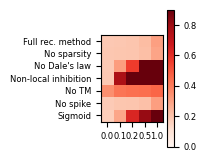

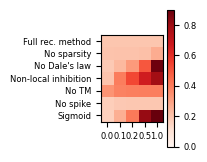

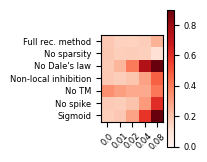

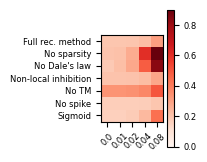

In [8]:
model_names_order = ["base", "Full rec. method", "No sparsity", "No Dale's law", "Non-local inhibition", "No TM", "No spike",  "No spike + reset", "Sigmoid"]
model_names_order = ["base", "Full rec. method", "No sparsity", "No Dale's law", "Non-local inhibition", "No TM", "No spike", "Sigmoid"]
remove_seed = df.groupby(["hypothesis", "model_name", "activation", "power"]).mean()
remove_seed.reset_index(inplace=True)

models_len = len(model_names_order)
matrices = np.zeros((2*2, models_len-1, 5))
i = 0
for measure in ["t_trial_21"]:#, "t_trial12"]:
    for activation in [0, 1]:
        for hypothesis in ["withfb1", "nofb"]:
            act = remove_seed[remove_seed.activation == activation]
            act = pd.pivot(act, index=["hypothesis", "model_name", "activation"], columns="power", values=measure)
            hyp_act = act.iloc[act.index.get_level_values('hypothesis') == hypothesis]
            hyp_act = hyp_act.reset_index(level=[0,2]).drop(columns=["hypothesis", "activation"]).reindex(model_names_order)
            hyp_act = hyp_act.loc[hyp_act.index != "No spike + reset", :]
            values = hyp_act.to_numpy()
            values = np.abs(values)# - values[0])
            fig, ax = plot_with_size(20, 35)
            # plt.title(f"{hypothesis} {measure} {activation}")
            im = ax.imshow(values[1:], cmap="Reds", vmin=0., vmax=0.9)
            plt.colorbar(im)
            ax.set_yticks(np.arange(models_len-1))
            ax.set_yticklabels(["" for i in range(models_len-1)])
            ax.set_yticklabels(model_names_order[1:])
            ax.set_xticks(np.arange(5))
            ax.set_xticklabels(hyp_act.columns.values)
            if activation:
                # Rotate the tick labels and set their alignment.
                plt.setp(ax.get_xticklabels(), rotation=45)
            fig.savefig(f"FiguresOpto/Figure2/{hypothesis}_{measure}_{activation}.pdf", bbox_inches="tight")
            matrices[i] = values[1:]
            i += 1

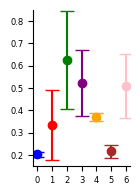

In [10]:
colors = np.array(["blue", "red", "green", "purple", "orange", "brown", "pink"])

fig, ax = plot_with_size(25, 40)
conf_int = 1.96 * np.std(matrices, axis=(0,2)) / np.sqrt(8*5)
for i in range(len(colors)):
    plt.errorbar([i], np.mean(matrices, axis=(0, 2))[i], yerr=conf_int[i], color=colors[i], fmt="o", capsize=5)
plt.ylim(0.15, 0.85)
strip_right_top_axis(ax)
ax.set_xticks(np.arange(models_len-1))#, model_names_order[1:], rotation=45)
fig.savefig("FiguresOpto/Figure2/best_model.pdf", bbox_inches="tight")

In [11]:
def run_over_version(logs, area_light, tt_plot, power, activation, trials, axs, spikes_rc, trial_types_rc, colors, linewidth=0.8, thr=8, skip_list=["No spike + reset"], tt_check=3):
    dp_hit_rns_mean = []
    dp_hit_rns_var = []
    k = 0
    for log in logs:
        opt = load_training_opt(log)
        model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
        name = give_name(log)
        if name in skip_list:
            continue
        power_mul = 1 if model.opt.spike_function == "sigmoid" else 1
        filt, trial_types_light, _, spikes = run_with_perturbation(model, area_light, activation, power=power*power_mul, seed=1, trials=trials, thr=thr)
        _, trial_types_nopower, _, _ = run_with_perturbation(model, area_light, activation, power=0, seed=0, trials=trials, thr=thr)
        keep = torch.isin(trial_types_nopower, torch.tensor([0,3], device=trial_types_nopower.device))
        trial_types_nopower = trial_types_nopower[keep]
        print(log)
        mean_rn1 = ((trial_types_light==tt_check)*1.).mean().item()
        mean_rn1_nopower = ((trial_types_nopower==tt_check)*1.).mean().item()
        dp_hit_rn1_mean = mean_rn1_nopower - mean_rn1
        var_rn1 = ((trial_types_light==tt_check)*1.).var().item()
        var_rn1_nopower = ((trial_types_nopower==tt_check)*1.).var().item()
        dp_hit_rn1_var = var_rn1 + var_rn1_nopower
        
        dp_hit_rns_mean.append(dp_hit_rn1_mean)
        dp_hit_rns_var.append(dp_hit_rn1_var)
        filt = model.filter_fun1(spikes) / model.timestep
        filt_rc = model.filter_fun1(spikes_rc) / model.timestep
        axs[k].set_title(name)
        time = np.arange(filt_rc.shape[0]) / filt_rc.shape[0] * 0.2 - 0.05
        area_check = 1 - area_light
        area_check = (model.rsnn.area_index == area_check)
        axs[k].plot(time, filt_rc[:, trial_types_rc==tt_plot][:,:, area_check].mean((1,2)).cpu(), alpha=0.7, color="black", linewidth=linewidth, linestyle="--")
        axs[k].plot(time, filt[:, trial_types_light==tt_plot][:,:, area_check].mean((1,2)).cpu(), alpha=0.7, color=colors[name], linewidth=linewidth)
        k += 1
    return dp_hit_rns_mean, dp_hit_rns_var

In [12]:
def Figure2A(area_light, activation, power, tt, logs, ylim=(0, 7,5), thr=8, trials=500, tt_check=3):
    colors = {"base":"black",  "No sparsity": "red", "Full rec. method": "blue", "Non-local inhibition": "green", "No inh across no EI":"purple", "No TM": "orange", "No Dale's law": "purple", "No spike": "brown", "No spike + reset": "gold", "Sigmoid": "pink"}
    # names = ["teachers", "Full rec. method", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike", "No spike + reset", "Sigmoid"]
    names = ["base", "Full rec. method", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike",  "Sigmoid"]
    opt_rc1 = load_training_opt(logs["nofb"][0])
    model_rc1 = load_model_and_optimizer(opt_rc1, reload=True, last_best="best")[0]
    opt_rc2 = load_training_opt(logs["withfb1"][0])
    model_rc2 = load_model_and_optimizer(opt_rc2, reload=True, last_best="best")[0]
    _, trial_types_rc1, _, spikes_rc1 = run_with_perturbation(model_rc1, area_light, activation, power=power, seed=0, trials=trials, thr=thr)
    _, trial_types_nopower, _, _ = run_with_perturbation(model_rc1, area_light, activation, power=0, seed=0, trials=trials, thr=thr)
    
    mean_rc1 = ((trial_types_rc1==tt_check)*1.).mean().item()
    mean_rc1_nopower = ((trial_types_nopower==tt_check)*1.).mean().item()
    dp_hit_rc1_mean = mean_rc1_nopower - mean_rc1
    var_rc1 = ((trial_types_rc1==tt_check)*1.).var().item()
    var_rc1_nopower = ((trial_types_nopower==tt_check)*1.).var().item()
    dp_hit_rc1_var = var_rc1 + var_rc1_nopower

    _, trial_types_rc2, _, spikes_rc2 = run_with_perturbation(model_rc2, area_light, activation, power=power, seed=0, trials=trials, thr=thr)
    _, trial_types_nopower, _, _ = run_with_perturbation(model_rc2, area_light, activation, power=0, seed=0, trials=trials, thr=thr)
   
    mean_rc2 = ((trial_types_rc2==tt_check)*1.).mean().item()
    mean_rc2_nopower = ((trial_types_nopower==tt_check)*1.).mean().item()
    dp_hit_rc2_mean = mean_rc2_nopower - mean_rc2
    var_rc2 = ((trial_types_rc2==tt_check)*1.).var().item()
    var_rc2_nopower = ((trial_types_nopower==tt_check)*1.).var().item()
    dp_hit_rc2_var = var_rc2 + var_rc2_nopower

    
    figs, axs = [], []
    models_len  = len(names) - 1
    for i in range(models_len):
        fig, ax = plot_with_size(25, 15)
        ax.set_ylim(ylim[0],ylim[1])
        strip_right_top_axis(ax)
        figs.append(fig)
        axs.append(ax)
    dp_hit_rns1_mean, dp_hit_rns1_var = run_over_version(logs["nofb"][2::3], area_light, tt, power, activation, trials, axs, spikes_rc1, trial_types_rc1, colors=colors, linewidth=1.5)
    dp_hit_rns2_mean, dp_hit_rns2_var = run_over_version(logs["withfb1"][2::3], area_light, tt, power, activation, trials, axs, spikes_rc2, trial_types_rc2, colors=colors)
    for i in range(models_len):
        figs[i].savefig(f"FiguresOpto/Figure2/Figure2b_act{activation}_{names[i+1]}.pdf", bbox_inches='tight', transparent=True)

    dp_hit_rc1, dp_hit_rc2 = np.array(dp_hit_rc1_mean), np.array(dp_hit_rc2_mean)
    dp_hit_rns1, dp_hit_rns2 = np.array(dp_hit_rns1_mean), np.array(dp_hit_rns2_mean)
    dp_hit_rc1_var, dp_hit_rc2_var = np.array(dp_hit_rc1_var), np.array(dp_hit_rc2_var)
    dp_hit_rns1_var, dp_hit_rns2_var = np.array(dp_hit_rns1_var), np.array(dp_hit_rns2_var)

    dp_total1 = np.concatenate(([dp_hit_rc1], dp_hit_rns1))
    dp_total2 = np.concatenate(([dp_hit_rc2], dp_hit_rns2))
    dp_total1_var = np.concatenate(([dp_hit_rc1_var], dp_hit_rns1_var))
    dp_total2_var = np.concatenate(([dp_hit_rc2_var], dp_hit_rns2_var))

    sem1 = 1.96 * (dp_total1_var / trials)**0.5
    sem2 = 1.96 * (dp_total2_var / trials)**0.5

    fig, ax = plot_with_size(30, 15)
    for i in range(models_len+1):
        ax.scatter(i, dp_total1[i], marker='x', color=colors[names[i]], s=40)
        ax.scatter(i, dp_total2[i], marker='o', color=colors[names[i]], s=40)
        # ax.errorbar([names[i]], dp_total1[i], yerr=sem1[i], fmt='x', color=colors[names[i]], markersize=4, capsize=2, linewidth=0.5)
        # ax.errorbar([names[i]], dp_total2[i], yerr=sem2[i], fmt='o', color=colors[names[i]], markersize=4, capsize=2, linewidth=0.5)
    strip_right_top_axis(ax)
    fig.savefig(f"FiguresOpto/Figure2/Figure2c_act{activation}_total.pdf", transparent=True, bbox_inches="tight")

In [13]:
def change_hit(log, trial_types_nopower, area_light, activation, power, tt, trials=500, thr=8):
    opt = load_training_opt(log)
    model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
    _, trial_types, _, _ = run_with_perturbation(model, area_light, activation, power=power, seed=0, trials=trials, thr=thr)
    mean = ((trial_types==tt)*1.).mean().item()
    mean_nopower = ((trial_types_nopower==tt)*1.).mean().item()
    var = ((trial_types==tt)*1.).var().item()
    var_nopower = ((trial_types_nopower==tt)*1.).var().item()
    dp_hit_mean = mean_nopower - mean
    dp_hit_var = var + var_nopower
    return dp_hit_mean, dp_hit_var


In [14]:
# Panel 2B

models_nofb = []
for log in [logs["nofb"][0]] + logs["nofb"][2::3]:
    opt = load_training_opt(log)
    model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
    models_nofb.append(model)

models_withfb1 = []
for log in [logs["withfb1"][0]] + logs["withfb1"][2::3]:
    opt = load_training_opt(log)
    model = load_model_and_optimizer(opt, reload=True, last_best="best")[0]
    models_withfb1.append(model)

trials, thr = 500, 8
trial_types_nopower_nofb = []
for model in models_nofb:
    _, trial_types_nopower, _, _ = run_with_perturbation(model, 0, 0, power=0, seed=0, trials=trials, thr=thr)
    trial_types_nopower_nofb.append(trial_types_nopower)
trial_types_nopower_withfb1 = []
for model in models_withfb1:
    _, trial_types_nopower, _, _ = run_with_perturbation(model, 0, 0, power=0, seed=0, trials=trials, thr=thr)
    trial_types_nopower_withfb1.append(trial_types_nopower)

df = pd.DataFrame(columns=["hypothesis", "model_name", "dp_hit_mean", "dp_hit_var", "activation", "power", "area_light"])
for models, hypothesis, trial_types_nopower in zip([models_nofb, models_withfb1], ["nofb", "withfb1"], [trial_types_nopower_nofb, trial_types_nopower_withfb1]):
    for i, model in enumerate(models):
        name = give_name(model.opt.log_path)
        if i == 0:
            name = "base"
        for power, activation in zip([1, 0.08], [0, 1]):
            for area_light in [0, 1]:
                _, trial_types_light, _, _ = run_with_perturbation(model, area_light, activation, power=power, seed=1, trials=trials, thr=thr)
                if area_light == 0:
                    dp_hit_mean = (((trial_types_light%2)==1)*1.).mean().item() - ((trial_types_nopower[i]==3)*1.).mean().item()
                    dp_hit_var = (((trial_types_light%2)==1)*1.).var().item() + ((trial_types_nopower[i]==3)*1.).var().item()
                else:
                    dp_hit_mean = (((trial_types_light//2)==1)*1.).mean().item() - ((trial_types_nopower[i]==3)*1.).mean().item()
                    dp_hit_var = (((trial_types_light//2)==1)*1.).var().item() + ((trial_types_nopower[i]==3)*1.).var().item()
                entry = {"hypothesis":hypothesis, "model_name": name, "dp_hit_mean": dp_hit_mean, "dp_hit_var": dp_hit_var, "activation": activation, "power": power, "area_light": area_light}
                df = pd.concat([df, pd.DataFrame(entry, index=[0])], ignore_index=True)




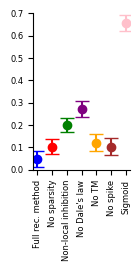

In [15]:
colors = ["blue", "red", "green", "purple", "orange", "brown", "pink"]

summary = df.loc[df.model_name != "base"]
base = df.loc[df.model_name == "base"]
for hypothesis in ["withfb1", "nofb"]:
    for activation, power, area_light in zip([0, 1, 0, 1], [1, 0.08, 1, 0.08], [0, 0, 1, 1]):
        cond = (summary.hypothesis == hypothesis) & (summary.activation == activation) & (summary.power == power) & (summary.area_light == area_light)
        cond_base = (base.hypothesis == hypothesis) & (base.activation == activation) & (base.power == power) & (base.area_light == area_light)
        summary.loc[cond, "dp_hit_mean"] = np.abs(summary.loc[cond, "dp_hit_mean"].values- base.loc[cond_base, "dp_hit_mean"].values)

summary = summary.groupby("model_name").mean(["dp_hit_mean", "dp_hit_var"])
conditions = 2 * 2 # to make mean as sum for the variance
summary = summary.loc[["Full rec. method", "No sparsity", "Non-local inhibition", "No Dale's law", "No TM", "No spike",  "Sigmoid"]]
names = summary.index.values
means = summary.dp_hit_mean.values
vars = summary.dp_hit_var.values * 2 / conditions

fig, ax = plot_with_size(25, 40)
# the * 2 is to take account for the substraction from the base model
for i in range(len(colors)):
    plt.errorbar([names[i]], means[i], yerr=1.96 * (vars[i] / trials)**0.5, fmt="o", capsize=5, color=colors[i])
plt.ylim(0, 0.7)
strip_right_top_axis(ax)
# rotate the tick labels for the x axis
plt.xticks(rotation=90)
ax.set_xticks(np.arange(len(names)))#, model_names_order[1:], rotation=45)
fig.savefig("FiguresOpto/Figure2/delta_hit.pdf", bbox_inches="tight")

log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_42_nofb_full_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nosparsity_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_noinhacross_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_46_nofb_noei_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_5_48_nofb_notm_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nospike_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_nofb_sigmoid_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_withfb1_full_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_38_withfb1_nosparsity_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_noinhacross_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_44_25_withfb1_noei_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_3_54

findfont: Font family ['arial'] not found. Falling back to DejaVu Sans.


log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_6_30_withfb1_sigmoid_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_42_nofb_full_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nosparsity_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_46_nofb_noinhacross_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_46_nofb_noei_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_15_5_48_nofb_notm_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_40_47_nofb_nospike_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_nofb_sigmoid_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_45_54_withfb1_full_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_49_38_withfb1_nosparsity_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_46_5_withfb1_noinhacross_1
log_dir/4f811b0a7d426989a9069580e0108cc3e5ac7d60/2024_11_12_14_44

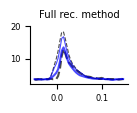

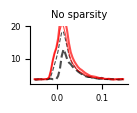

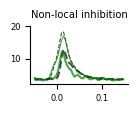

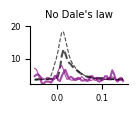

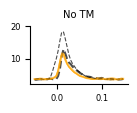

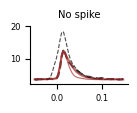

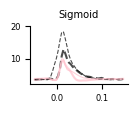

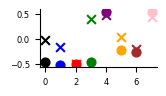

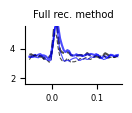

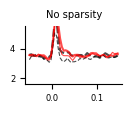

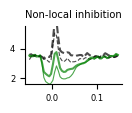

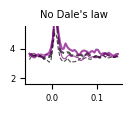

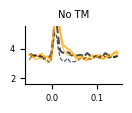

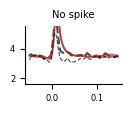

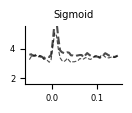

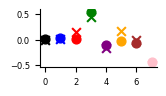

In [16]:
# Panel 2A

# # activation
trials = 500
# area_light, activation, power, tt = 0, 1, 0.08, 3
# Figure2A(area_light, activation, power, tt, logs, ylim=(2, 25))

# # activation
area_light, activation, power, tt = 1, 1, 0.08, 3
Figure2A(area_light, activation, power, tt, logs, ylim=(2, 20))

# # inactivation
# area_light, activation, power, tt = 0, 0, 1, 2
# Figure2A(area_light, activation, power, tt, logs, ylim=(1.8, 4.2))
# inactivation
area_light, activation, power, tt = 1, 0, 1, 1
Figure2A(area_light, activation, power, tt, logs, ylim=(1.6, 5.5))